# 0 Preparación del entorno.

## 0.1 Definición de parámetros

In [9]:
import os

In [10]:
tfm_path='/content/drive/MyDrive/TFM data/'
H1_code = 'OMNI2_H0_MRG1HR'
M5_code = 'OMNI_HRO2_5MIN'
lookback = 12
lookforward = 6
tfm_path_Nh_models = f'PRED_{lookforward}h/'
cols_to_use = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst'] # 'AP', out
col_to_predict = "Dst"
hstorms_data = 'historical_storms_gruet2018.csv'
weak_threshold = -30 #1
moderate_threshold = -50 #2
strong_threshold = -100 #3
severe_threshold = -200 #4
great_threshold = -300 #5
gamma_value=0.0001
temporal_margin=5*24 # margen para obtener tiempos ampliados de las tormentas de gruet et al 2018
test_size = 0.2
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

In [11]:
PATH_NN_RES_BY_STORM = "/content/drive/MyDrive/TFM data/RESULTADOS/SVR_{}h_res_by_storm/storm_{}.csv"
PATH_NN_RES_BY_STORM_PLOTS = "/content/drive/MyDrive/TFM data/RESULTADOS/SVR_{}h_res_by_storm/storm_{}.png"

## 0.2 Montar Google Drive (obtención de datos)

In [12]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Crear el directorio
os.makedirs('/content/drive/MyDrive/TFM data/RESULTADOS/', exist_ok=True)

## 0.3 Importación de librerías

In [14]:
# !pip install optuna

In [15]:
import os

import numpy as np

# librerías de manipulación de datos y gráficos
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# modelo
from sklearn.svm import SVR
#from thundersvm import SVR
# escalado y división en train/test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# obtención de métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.metrics import explained_variance_score, max_error

# meta
# timer
import time

#optuna
import optuna

## 0.4 Definición de funciones

In [16]:
def exploracion_inicial_datos(df):
    """
    Función para realizar una exploración inicial de los datos.

    Parámetros:
    df (dataframe): El dataframe que contiene los datos.

    Muestra las primeras filas, estadísticas descriptivas, valores faltantes,
    histogramas de variables numéricas y un mapa de calor de la correlación.
    """
    # Configuración de visualización
    sns.set(style="whitegrid")  # Estilo de gráficos


    print("Primeras filas del DataFrame:")
    print(df.head())


    print("\nDescripción estadística de los datos:")
    print(df.describe())


    print("\nValores faltantes por columna:")
    print(df.isnull().sum())


    print("\nVisualización de histogramas para variables numéricas:")
    df.hist(bins=15, figsize=(15, 10), layout=(5, 4))
    plt.show()
    print("\nMapa de calor de la matriz de correlación:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()


def calcular_layout_optimo(num_cols):
    """
    Calcula el número óptimo de filas y columnas para una figura con subgráficos,
    tratando de mantener una forma que sea visualmente agradable y que aproveche el espacio.

    Parámetros:
    num_cols (int): Número total de columnas (gráficos) a mostrar.

    Retorna:
    (int, int): Número de filas y columnas para el layout de los subgráficos.
    """
    # Calcula el número óptimo de columnas teniendo un límite visual razonable
    cols_per_row = int(np.sqrt(num_cols)) + 1  # Ajuste para maximizar el uso del espacio y la forma de la figura
    rows_needed = (num_cols + cols_per_row - 1) // cols_per_row  # Redondeo hacia arriba para incluir todas las columnas
    return rows_needed, cols_per_row

def exploracion_histogramas(df):
    """
    Función para generar histogramas para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Número de columnas numéricas
    num_cols = df_numerico.shape[1]

    # Verificar si hay columnas para mostrar
    if num_cols == 0:
        print("No hay columnas numéricas para mostrar.")
        return

    # Calculando el layout necesario
    rows_needed, cols_per_row = calcular_layout_optimo(num_cols)

    # Crear histogramas
    df_numerico.hist(bins=15, figsize=(15, 10), layout=(rows_needed, cols_per_row))
    plt.show()

def imputar_nan(df):
  df.interpolate(method='linear', inplace=True)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  if sum(df.isnull().sum())!=0:
    print("Faltan nulos por tratar")
  return df

def visualizar_nulos_plot(df, variable_with_nans):
    """
    Plot the specified 'variable_with_nans' column and 'Dst' column from the DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data to plot.
    - variable_with_nans: str, the name of the column in the DataFrame to plot, which may contain NaNs.

    The function assumes that 'Dst' is a column name in the DataFrame and that the DataFrame's index is suitable for plotting (e.g., datetime).
    """
    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

    # Handling NaNs in the 'variable_with_nans' column before plotting
    df_plot = df.copy()
    df_plot[variable_with_nans] = df_plot[variable_with_nans].fillna(method='ffill')  # Forward fill to handle NaNs

    # Plotting 'variable_with_nans' on the first subplot
    ax1.scatter(df_plot.index, df_plot[variable_with_nans], label=variable_with_nans, color='blue')
    ax1.set_ylabel(variable_with_nans)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plotting 'Dst' on the second subplot
    ax2.plot(df_plot.index, df_plot['Dst'], label='Dst', color='red')
    ax2.set_ylabel('Dst')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Setting the x-axis label only on the bottom subplot
    ax2.set_xlabel('Datetime')

    # Improve layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example of how to use this function with a DataFrame containing NaNs
data = {
    'Datetime': pd.date_range(start='2021-01-01', periods=100, freq='D'),
    'variable_with_nans': pd.Series(range(100)).where(lambda x : x % 10 != 0),
    'Dst': range(100, 0, -1)
}
df = pd.DataFrame(data)
df.set_index('Datetime', inplace=True)

def create_window_df_svr(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_label=None):
    """
    Creates input and output datasets for SVR training from a list of DataFrames, incorporating windowing and optional descaling for target

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to process.
    lookback (int): Number of past records to include as features for each prediction.
    lookforward (int): Number of records ahead to predict.
    cols_to_use (list of str): List of column names to use as features.
    col_to_predict (str): Column name to predict.
    scaler_label (StandardScaler, optional): Scaler for the output variable, used for inverse transformation.

    Returns:
    tuple: A tuple containing arrays for training features and labels.
    """
    x_train, y_train = [], []

    for df_ in list_dfs:
        df = df_.copy()

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
            y_train.append(np.asarray(df.iloc[i+lookback][col_to_predict]))

    if scaler_label is not None:
        y_train = scaler_label.inverse_transform(np.asarray(y_train).reshape(-1,1))

    return np.asarray(x_train), np.asarray(y_train)


def filter_storms(df, historical_storms, temporal_margin):
    """
    Filter DataFrame entries based on the occurrence of storms within specific time intervals.

    Parameters:
    df (pandas.DataFrame): DataFrame containing time-series data with a 'Datetime' column.
    historical_storms (pandas.DataFrame): DataFrame containing the start and end times of historical storms.
    temporal_margin (int): Number of rows before and after the minimum Dst index to include in the result.

    Returns:
    list: A list of DataFrame snippets corresponding to the specified storm intervals.
    """
    all_storms = []
    for i in range(len(historical_storms)):
        df_tmp = df[(df["Datetime"] >= historical_storms.iloc[i]["start"]) & (df["Datetime"] <= historical_storms.iloc[i]["end"])]
        idx = df_tmp['Dst'].idxmin()
        all_storms.append(df.iloc[idx-temporal_margin:idx+temporal_margin])
    return all_storms

def combinar_dataframes_solapados(dfs):
    """
    Combines overlapping DataFrames in a list into non-overlapping DataFrames based on the 'Datetime' column.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames to combine.

    Returns:
    list: A list of combined DataFrames without overlap.
    """
    dfs.sort(key=lambda x: x['Datetime'].min())
    combinados = []
    combinacion_actual = dfs[0]

    for df in dfs[1:]:
        if df['Datetime'].min() <= combinacion_actual['Datetime'].max():
            combinacion_actual = pd.concat([combinacion_actual, df]).drop_duplicates().sort_values(by='Datetime')
        else:
            combinados.append(combinacion_actual)
            combinacion_actual = df
    combinados.append(combinacion_actual)
    return combinados

def scale_data(list_dfs, cols_to_use, col_to_predict):
    """
    Scales columns in a list of DataFrames using StandardScaler.

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to scale.
    cols_to_use (list of str): Column names to apply scaling to.
    col_to_predict (str): Column name used as a label for prediction.

    Returns:
    tuple: A tuple containing the list of scaled DataFrames and the label scaler.
    """
    list_dfs_ = []
    scaler_cols = StandardScaler()
    scaler_label = StandardScaler()
    scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
    scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

    for df_ in list_dfs:
        df = df_.copy()
        df[cols_to_use] = scaler_cols.transform(df[cols_to_use])
        list_dfs_.append(df)

    return list_dfs_, scaler_label



def calc_metrics(predictions, y_test):
  # Mean Squared Error
  mse = mean_squared_error(y_test, predictions)
  # Mean Absolute Error
  mae = mean_absolute_error(y_test, predictions)
  # R^2 Score, the coefficient of determination
  r2 = r2_score(y_test, predictions)
  # Median Absolute Error
  medae = median_absolute_error(y_test, predictions)
  # Explained Variance Score
  explained_variance = explained_variance_score(y_test, predictions)
  # Max Error
  max_err = max_error(y_test, predictions)

  return mse, mae, r2, medae, explained_variance, max_err


def formatear_tiempo(segundos):
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segundos = segundos % 60
    return f"{horas} horas, {minutos} minutos, {segundos:.2f} segundos"


In [17]:
def evaluate_svr_models(X_train, y_train, X_test, y_test, kernels, C_values, epsilon_values, gamma_values, degree_values, verbose=True):
    """
    Evaluate SVR models with different hyperparameter configurations and kernel types.

    Args:
    X_train (array): Independent training data.
    y_train (array): Dependent training data (target).
    X_test (array): Independent test data.
    y_test (array): Dependent test data (target).
    kernels (list): List of kernel types to evaluate.
    C_values (list): List of values for the penalty parameter C.
    epsilon_values (list): List of values for the epsilon parameter.
    gamma_values (list): List of values for the gamma parameter.
    degree_values (list): List of values for the degree parameter (used only in polynomial kernels).
    verbose (bool, optional): If True, prints messages during the evaluation process. Default is True.

    Returns:
    DataFrame: A pandas DataFrame containing evaluation metrics for each parameter configuration.
    dict: A dictionary of trained models, with keys describing the specific parameter configuration.

    Note:
    Assumes that the 'precomputed' kernel is only used if the 'precomputed_matrix' is defined in the local environment.
    """
    results = []
    models_dict = {}

    for kernel_ in kernels:
        for C in C_values:
            for epsilon in epsilon_values:
                # Check parameter relevance for gamma and degree for the current kernel
                relevant_gamma_values = gamma_values if kernel_ in ['rbf', 'sigmoid', 'poly'] else [None]
                relevant_degree_values = degree_values if kernel_ == 'poly' else [None]

                for gamma in relevant_gamma_values:
                    for degree in relevant_degree_values:
                        start = time.time()
                        config_key = f"{kernel_}_C{C}_eps{epsilon}_gamma{gamma}_deg{degree}"
                        if verbose:
                            print(f"Starting {config_key}")

                        if kernel_ == "precomputed":
                            if 'precomputed_matrix' in locals():
                                model = SVR(kernel='precomputed', C=C, epsilon=epsilon)
                                model.fit(precomputed_matrix, y_train)
                                models_dict[config_key] = model
                                continue
                            else:
                                if verbose:
                                    print("Precomputed matrix not defined for kernel='precomputed'")
                                continue

                        model = SVR(kernel=kernel_, C=C, epsilon=epsilon, gamma=(gamma if gamma is not None else 0.01), degree=(degree if degree is not None else 3))
                        model.fit(X_train, y_train)
                        models_dict[config_key] = model

                        predictions = model.predict(X_test)
                        mse, mae, r2, medae, explained_variance, max_err = calc_metrics(predictions, y_test)
                        end = time.time()
                        time_exec = formatear_tiempo(end - start)

                        results.append({
                            "kernel": kernel_,
                            "C": C,
                            "epsilon": epsilon,
                            "gamma": gamma,
                            "degree": degree,
                            "mse": mse,
                            "mae": mae,
                            "r2": r2,
                            "medae": medae,
                            "exp_var": explained_variance,
                            "max_err": max_err,
                            "time_exec": time_exec
                        })

                        print(f"{config_key} finished. Time for iteration: {time_exec} | mae: {mae} | mse: {mse} | exp_var: {explained_variance} | max_err: {max_err}")

    df_results = pd.DataFrame(results)
    return df_results, models_dict


Función para extraer las fechas de la nueva división de datos, una vez ampliadas las ventanas de cada tormenta a +-5 días desde el mínimo de cada tormenta, y eliminados los datos solapados

In [18]:
def get_new_splits_dates(all_storms):
    dates_start = []
    dates_end = []
    num_storm = []
    min_dst_values = []

    for idx, df in enumerate(all_storms):
        dates_start.append(df["Datetime"].iloc[0])
        dates_end.append(df["Datetime"].iloc[-1])
        num_storm.append(idx+1)
        min_dst_values.append(df["Dst"].min())
    df_new_storms = pd.DataFrame(
        {
            "storm_index": num_storm,
            "date_start": dates_start,
            "date_end": dates_end,
            "min_DST": min_dst_values
        }
    )
    return df_new_storms

Función para sacar los scalers de las variables de input y de la label (Dst)

In [19]:
def get_scalers(list_dfs, cols_to_use, col_to_predict):
    list_dfs_ = []
    scaler_cols = StandardScaler()
    scaler_label = StandardScaler()
    scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
    scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

    return scaler_cols, scaler_label

Nueva función para crear ventanas de datos para input del modelo

In [20]:
def create_window_df_nn(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols):
    x_train, y_train = [], []

    for df_ in list_dfs:
        df = df_[cols_to_use].copy()
        df.loc[:, cols_to_use] = scaler_cols.transform(df[cols_to_use])

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback].values))
            y_train.append(np.asarray(df.iloc[i+lookback+lookforward-1][col_to_predict]))

    return np.asarray(x_train), np.asarray(y_train)

def create_window_df_nn_test(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols):
    x_train, y_train, date_pred, date_last_data = [], [], [], []

    for df_ in list_dfs:
        df = df_.copy()
        df.loc[:, cols_to_use] = scaler_cols.transform(df[cols_to_use])

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
            y_train.append(np.asarray(df.iloc[i+lookback+lookforward-1][col_to_predict]))
            date_last_data.append(df.iloc[i+lookback-1]["Datetime"])
            date_pred.append(df.iloc[i+lookback+lookforward-1]["Datetime"])

    return np.asarray(x_train), np.asarray(y_train), np.asarray(date_last_data), np.asarray(date_pred)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from math import sqrt
import sklearn

def error_nn(y_pred, y_true, index_scaler):
    y_pred = index_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_true = index_scaler.inverse_transform(y_true.reshape(-1, 1))

    print(y_pred.reshape(-1).shape)
    print(y_true.reshape(-1).shape)
    df_ = pd.DataFrame({"y_pred": y_pred.reshape(-1), "y_true": y_true.reshape(-1)})

    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Median Absolute Error
    medae = median_absolute_error(y_true, y_pred)
    # Explained Variance Score
    explained_variance = explained_variance_score(y_true, y_pred)
    # Max Error
    max_err = max_error(y_true, y_pred)


    data = {
        'Métrica': ['RMSE', 'MSE', 'MAE', 'R²', 'MedAE', 'Varianza explicada', 'Max error'],
        'Valor': [rmse, mse, mae, r2, medae, explained_variance, max_err]
    }
    df = pd.DataFrame(data)
    df_invertido = df.transpose()
    df_invertido.columns = df_invertido.iloc[0]
    df_invertido = df_invertido[1:]
    display(df_invertido)

    # scatter plot
    plt.figure(figsize=(8, 4))
    plt.scatter(y_true, y_pred, c='blue', label='Predicciones vs. Valores reales')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2, label='Línea de referencia')
    plt.xlabel('Valores reales')
    plt.ylabel('Predicciones')
    plt.title('Diagrama de dispersión de Predicciones vs. Valores reales')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

# 1. Carga y preparación de datos

## 1.1 Carga de los datos

In [22]:
hd = pd.read_csv(tfm_path+H1_code+'.csv', parse_dates=["Datetime"])
# md = pd.read_csv(tfm_path+M5_code+'.csv', parse_dates=["Datetime"]) # no se va a usar por ahora
historical_storms = pd.read_csv(tfm_path+hstorms_data)
# historical_storms = historical_storms.drop(columns=['Min. Dst (nT)','Unnamed: 0'], axis=1)

- Ver qué columnas y tipo de datos contienen los df.

In [23]:
hd.columns

Index(['ID_IMF', 'ID_plasma', 'Bmag', 'dev_Bmag', 'Bx', 'By_gse', 'Bz_gse',
       'By_gsm', 'Bz_gsm', 'dev_Bx', 'dev_By', 'dev_Bz', 'P_density',
       'dev_P_density', 'AP', 'dev_AP', 'E_field', 'plasma_T', 'dev_plasma_T',
       'plasma_V', 'Dst', 'Datetime'],
      dtype='object')

In [24]:
hd.dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

In [25]:
historical_storms.columns

Index(['Unnamed: 0', 'Min. Dst (nT)', 'start', 'end', 'storm'], dtype='object')

In [26]:
historical_storms.dtypes

Unnamed: 0        int64
Min. Dst (nT)     int64
start            object
end              object
storm             int64
dtype: object

- Ordenar las tormentas en caso de que no lo estén
- Convertir todas las fechas a datetime de pd.

In [27]:
# Ordenar los dataframes por fecha
historical_storms = historical_storms.sort_values(by='start')

# convertir las columnas de tiempo a datetime64
hd['Datetime']=pd.to_datetime(hd['Datetime'])
historical_storms['start']=pd.to_datetime(historical_storms['start'])
historical_storms['end']=pd.to_datetime(historical_storms['end'])

# Cuando se utilizan los datos a 5 minutos, se unen a 5min
#data = pd.merge(md, hd[["Datetime", "Dst"]], on='Datetime', how='left')

## 1.2 Exploración inicial de los datos

- head del df

In [28]:
# hd.head()

- descripción estadística de los datos

In [29]:
# hd.describe()

- ver los valores nulos

In [30]:
# hd.isnull().sum()

In [31]:
# hd.isnull().sum() / len(hd) * 100

- Histograma para variables numéricas (todas, en este caso, pero hemos quitado datetime porque no es muy util al ser una serie temporal).

In [32]:
# exploracion_histogramas(hd)

- Visualizaciónd e historical_storms

In [33]:
# storms_data = historical_storms.copy()

In [34]:
# # Convertir las columnas de fecha y hora a datetime
# storms_data['start'] = pd.to_datetime(storms_data['start'])
# storms_data['end'] = pd.to_datetime(storms_data['end'])
# # Calcular la duración de cada tormenta en horas
# storms_data['duration_hours'] = (storms_data['end'] - storms_data['start']).dt.total_seconds() / 3600

# # Gráfico de la distribución de las intensidades mínimas de las tormentas
# plt.figure(figsize=(8, 4))
# sns.histplot(storms_data['Min. Dst (nT)'], bins=30, kde=True, color='blue')
# plt.title('Distribución de Intensidades Mínimas de Tormentas Geomagnéticas')
# plt.xlabel('Min. Dst (nT)')
# plt.ylabel('Frecuencia')
# plt.grid(True)
# plt.show()

Gráfico de dispersión entre la duración y la intensidad mínima

In [35]:
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='duration_hours', y='Min. Dst (nT)', data=storms_data)
# plt.title('Correlación entre Duración e Intensidad Mínima de Tormentas')
# plt.xlabel('Duración (Horas)')
# plt.ylabel('Min. Dst (nT)')
# plt.grid(True)
# plt.show()

- Ver el timeline de las tormentas

In [36]:
# import plotly.graph_objects as go

# # Crear la figura
# fig = go.Figure()

# # Añadir cada tormenta como un segmento de línea en el gráfico
# for i, row in storms_data.iterrows():
#     fig.add_trace(go.Scatter(
#         x=[row['start'], row['end']],
#         y=[i, i],
#         mode='lines+markers',
#         name=f"Tormenta {row['storm']}"
#     ))

# # Ajustar la presentación de la figura
# fig.update_layout(
#     title="Línea de Tiempo de Tormentas Históricas",
#     xaxis_title="Fecha",
#     yaxis_title="Tormenta",
#     yaxis=dict(
#         tickmode='array',
#         tickvals=list(range(len(storms_data)))
#     ),
#     showlegend=False,
#     xaxis=dict(
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     )
# )

# # Mostrar la figura
# fig.show()

Mapa de calor de la matriz de correlación

In [37]:
# plt.figure(figsize=(15, 8))
# sns.heatmap(hd.corr(), annot=True, fmt=".2f", cmap='coolwarm')
# plt.show()

## 1.3 Limpieza y procesamiento de los datos

### 1.3.1 Tratamiento de valores faltantes

In [38]:
sum(hd.isnull().sum())

42472

In [39]:
hd = imputar_nan(hd)

In [40]:
sum(hd.isnull().sum())

0

### 1.3.2 Normalización de los datos

In [41]:
all_storms = filter_storms(hd, historical_storms, temporal_margin)
all_storms = combinar_dataframes_solapados(all_storms)

In [42]:
historical_storms_new = get_new_splits_dates(all_storms)

Storm index de cada conjunto de datos, test y validación, entrenamiento el resto

In [43]:
index_test_storms = [2, 12, 23, 32, 8, 40, 42, 3, 31]
index_val_storms = [25, 13, 1, 37, 33, 7]

TORMENTAS DE ENTRENAMIENTO

In [44]:
train_storms = [df for idx, df in enumerate(all_storms) if idx not in [x-1 for x in index_test_storms]]
historical_storms_new[~historical_storms_new["storm_index"].isin(index_test_storms)].reset_index(drop=True)

,storm_index,date_start,date_end,min_DST
0,1,2001-03-15 13:00:00,2001-03-25 12:00:00,-149.0
1,4,2001-08-12 21:00:00,2001-08-22 20:00:00,-105.0
2,5,2001-09-26 08:00:00,2001-10-06 07:00:00,-166.0
3,6,2001-10-16 21:00:00,2001-11-02 10:00:00,-187.0
4,7,2002-03-19 09:00:00,2002-03-29 08:00:00,-100.0
5,9,2002-05-06 19:00:00,2002-05-16 18:00:00,-110.0
6,10,2002-05-18 17:00:00,2002-05-28 16:00:00,-109.0
7,11,2002-07-28 05:00:00,2002-08-07 04:00:00,-102.0
8,13,2002-09-26 16:00:00,2002-10-06 15:00:00,-176.0
9,14,2002-11-16 10:00:00,2002-11-26 09:00:00,-128.0


TORMENTAS DE TEST

In [45]:
test_storms = [df for idx, df in enumerate(all_storms) if idx in [x-1 for x in index_test_storms]]
historical_storms_new[historical_storms_new["storm_index"].isin(index_test_storms)].reset_index(drop=True)

,storm_index,date_start,date_end,min_DST
0,2,2001-03-26 08:00:00,2001-04-05 07:00:00,-387.0
1,3,2001-04-13 06:00:00,2001-04-27 14:00:00,-114.0
2,8,2002-04-13 07:00:00,2002-04-25 07:00:00,-149.0
3,12,2002-08-30 05:00:00,2002-09-12 23:00:00,-181.0
4,23,2004-07-18 02:00:00,2004-08-01 12:00:00,-170.0
5,31,2006-04-09 09:00:00,2006-04-19 08:00:00,-98.0
6,32,2006-12-10 07:00:00,2006-12-20 06:00:00,-162.0
7,40,2013-03-12 20:00:00,2013-03-22 19:00:00,-132.0
8,42,2014-02-14 08:00:00,2014-02-24 07:00:00,-119.0


Obtenemos scalers de input y label con todo el conjunto de datos

In [46]:
scaler_cols, scaler_label = get_scalers(all_storms, cols_to_use, col_to_predict)

Genereamos ventanas en el formato deseado de los conjuntos de entrenamiento test y validación

In [47]:
x_train, y_train = create_window_df_nn(train_storms, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols)
print("x_train shape : ", x_train.shape, "\ny_train shape:", y_train.shape)

x_train shape :  (7713, 12, 10) 
y_train shape: (7713,)


In [48]:
x_test, y_test = create_window_df_nn(test_storms, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols)
print("x_test shape : ", x_test.shape, "\ny_test shape:", y_test.shape)

x_test shape :  (2359, 12, 10) 
y_test shape: (2359,)


Necesario hacer reshape de las ventanas, flatten(). Requerimientos de SVR y algoritmos similares (XGBoost, RandomForest...)  
La shape de y_train, y_test se mantiene, comprobamos:

In [49]:
X_train = x_train.reshape(x_train.shape[0], -1)  # Transforma a (n_samples, n_features*lookback)
X_test = x_test.reshape(x_test.shape[0], -1)  # Lo mismo para el conjunto de prueba

print("x_train shape : ", X_train.shape, "\ny_train shape:", y_train.shape)
print("x_test shape : ", X_test.shape, "\ny_test shape:", y_test.shape)

x_train shape :  (7713, 120) 
y_train shape: (7713,)
x_test shape :  (2359, 120) 
y_test shape: (2359,)


### 1.3.3 Codificación de variables categóricas

* No existe codificación de variables categóricas porque **no hay variables categóricas). A continuación, se muestra.

In [50]:
pd.concat(all_storms).dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

# 3 Entrenamiento de modelos

## 3.1 Creación de la ventana temporal

Creada mas arriba create_window_df_nn()

## 3.2 División en train-test.

Dividido en apartado anteiror

## 4 Optimización de la selección de hiperparámetros

### Linear

In [53]:
# Define the full path to the SQLite database
database_path = os.path.join(tfm_path+tfm_path_Nh_models, f'DEF_kaisa_kernel_LINEAR_pred{lookforward}H_20240720.db')
storage_url = f'sqlite:///{database_path}'
new_study_name=f"DEF_kaisa_kernel_LINEAR_pred{lookforward}_20240720"

In [54]:
# Define el espacio de búsqueda de los hiperparámetros discretos
kernels = ['linear']

# Define el espacio de búsqueda de los hiperparámetros continuos discretizados
C_values = np.logspace(-3, 2, num=8)  # 10 valores entre 1e-3 y 1e3
epsilon_values = np.logspace(-4, 1, num=6)  # 10 valores entre 1e-4 y 1e1

In [55]:
from itertools import product
num_combinations = {
    'linear': len(list(product(C_values, epsilon_values))),
}
num_combinations['total'] = sum(num_combinations.values())
N_TRIALS = num_combinations["total"]
print(num_combinations)
print(N_TRIALS)

{'linear': 48, 'total': 48}
48


In [56]:
linear_time_max = N_TRIALS * 2
print(f"Esta optimización de hiperparámetros va a durar: {linear_time_max} minutos como máximo")

Esta optimización de hiperparámetros va a durar: 96 minutos como máximo


In [57]:
param_grid = {
    'kernel': kernels,
    'C': C_values,
    'epsilon': epsilon_values
}
sampler_opt = optuna.samplers.GridSampler(param_grid)

In [58]:
import optuna
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from threading import Thread

class TimeLimitExceeded(Exception):
    pass

# Define una función objetivo que Optuna utilizará para la optimización
def objective(trial):
    # Define los hiperparámetros comunes utilizando valores discretizados
    C = trial.suggest_categorical('C', C_values)
    epsilon = trial.suggest_categorical('epsilon', epsilon_values)
    kernel = trial.suggest_categorical('kernel', kernels)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel)

    # Define el límite de tiempo para cada ensayo
    timeout = 120  # 60 segundos

    def fit_and_predict():
        nonlocal mse
        # Entrena el modelo
        model.fit(X_train, y_train)
        # Realiza predicciones sobre el conjunto de prueba
        y_pred = model.predict(X_test)
        # Calcula el error cuadrático medio
        mse = mean_squared_error(y_test, y_pred)

    mse = float('inf')  # Valor predeterminado alto para MSE

    # Inicia el hilo para ejecutar el modelo con límite de tiempo
    thread = Thread(target=fit_and_predict)
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        # Si el hilo todavía está activo después del tiempo límite, levantamos una excepción
        raise TimeLimitExceeded("Trial timed out")

    return mse

# Crea un estudio de Optuna y optimiza la función objetivo
study = optuna.create_study(study_name=new_study_name, storage=storage_url, load_if_exists=True, direction='minimize', sampler=sampler_opt)

# Optimiza sin límite de tiempo total, pero con límite de tiempo por ensayo
study.optimize(objective, n_trials=N_TRIALS, catch=(TimeLimitExceeded,))

# Muestra los mejores hiperparámetros encontrados
print("Best hyperparameters: ", study.best_params)
print("Best MSE: ", study.best_value)

# Puedes también guardar el estudio para futuras referencias
study.trials_dataframe().to_csv(f"optuna_study_results_LINEAR_{lookforward}H.csv")

# Imprime el número total de ensayos realizados
print(f'Número de ensayos realizados por Optuna: {len(study.trials)}')

[I 2024-07-20 13:54:41,497] Using an existing study with name 'DEF_kaisa_kernel_LINEAR_pred6_20240720' instead of creating a new one.
[I 2024-07-20 13:54:41,816] Trial 21 finished with value: 15.329145935278072 and parameters: {'C': 0.7196856730011522, 'epsilon': 10.0, 'kernel': 'linear'}. Best is trial 18 with value: 0.4017928218995875.
[W 2024-07-20 13:56:42,062] Trial 22 failed with parameters: {'C': 3.7275937203149416, 'epsilon': 0.001, 'kernel': 'linear'} because of the following error: TimeLimitExceeded('Trial timed out').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-58-d1b9fd79399e>", line 42, in objective
    raise TimeLimitExceeded("Trial timed out")
TimeLimitExceeded: Trial timed out
[W 2024-07-20 13:56:42,070] Trial 22 failed with value None.
[W 2024-07-20 13:58:42,329] Trial 23 failed with parameters: {'C': 100.0, 'epsilon': 0.01

Best hyperparameters:  {'C': 0.02682695795279726, 'epsilon': 0.1, 'kernel': 'linear'}
Best MSE:  0.4017928218995875
Número de ensayos realizados por Optuna: 48


### RBF

In [59]:
# Define the full path to the SQLite database
database_path = os.path.join(tfm_path+tfm_path_Nh_models, f'DEF_kaisa_kernel_RBF_pred{lookforward}H_20240720.db')
storage_url = f'sqlite:///{database_path}'
new_study_name=f"DEF_kaisa_kernel_RBF_pred{lookforward}_20240720"

In [60]:
# Define el espacio de búsqueda de los hiperparámetros discretos
kernels = ['rbf']
gamma_values = ['scale', 'auto']  # Para el kernel 'rbf'

# Define el espacio de búsqueda de los hiperparámetros continuos discretizados
C_values = np.logspace(-3, 3, num=6)  # 10 valores entre 1e-3 y 1e3
epsilon_values = np.logspace(-4, 1, num=4)  # 10 valores entre 1e-4 y 1e1

In [61]:
num_combinations = {
    'rbf': len(list(product(gamma_values, C_values, epsilon_values)))
}
num_combinations['total'] = sum(num_combinations.values())
print(num_combinations)
N_TRIALS = num_combinations["total"]
print(N_TRIALS)

{'rbf': 48, 'total': 48}
48


In [62]:
param_grid = {
    'kernel': kernels,
    'gamma': gamma_values,
    'C': C_values,
    'epsilon': epsilon_values
}
sampler_opt = optuna.samplers.GridSampler(param_grid)

In [63]:
rbf_time_max = N_TRIALS * 2
print(f"Esta optimización de hiperparámetros va a durar: {rbf_time_max} minutos como máximo")

Esta optimización de hiperparámetros va a durar: 96 minutos como máximo


In [64]:
class TimeLimitExceeded(Exception):
    pass

# Define una función objetivo que Optuna utilizará para la optimización
def objective(trial):
    # Define los hiperparámetros comunes utilizando valores discretizados
    C = trial.suggest_categorical('C', C_values)
    epsilon = trial.suggest_categorical('epsilon', epsilon_values)
    kernel = trial.suggest_categorical('kernel', kernels)

    gamma = trial.suggest_categorical('gamma', gamma_values)
    model = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)

    # Define el límite de tiempo para cada ensayo
    timeout = 120  # 60 segundos

    def fit_and_predict():
        nonlocal mse
        # Entrena el modelo
        model.fit(X_train, y_train)
        # Realiza predicciones sobre el conjunto de prueba
        y_pred = model.predict(X_test)
        # Calcula el error cuadrático medio
        mse = mean_squared_error(y_test, y_pred)

    mse = float('inf')  # Valor predeterminado alto para MSE

    # Inicia el hilo para ejecutar el modelo con límite de tiempo
    thread = Thread(target=fit_and_predict)
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        # Si el hilo todavía está activo después del tiempo límite, levantamos una excepción
        raise TimeLimitExceeded("Trial timed out")

    return mse

# Crea un estudio de Optuna y optimiza la función objetivo
study = optuna.create_study(study_name=new_study_name, storage=storage_url, load_if_exists=True, direction='minimize', sampler=sampler_opt)

# Optimiza sin límite de tiempo total, pero con límite de tiempo por ensayo
study.optimize(objective, n_trials=N_TRIALS, catch=(TimeLimitExceeded,))

# Muestra los mejores hiperparámetros encontrados
print("Best hyperparameters: ", study.best_params)
print("Best MSE: ", study.best_value)

# Puedes también guardar el estudio para futuras referencias
study.trials_dataframe().to_csv(f"optuna_study_results_RBF_{lookforward}H.csv")

# Imprime el número total de ensayos realizados
print(f'Número de ensayos realizados por Optuna: {len(study.trials)}')


[I 2024-07-20 14:25:07,157] A new study created in RDB with name: DEF_kaisa_kernel_RBF_pred6_20240720
[W 2024-07-20 14:27:08,380] Trial 0 failed with parameters: {'C': 63.0957344480193, 'epsilon': 0.0001, 'kernel': 'rbf', 'gamma': 'scale'} because of the following error: TimeLimitExceeded('Trial timed out').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-64-57528c5b8ebb>", line 35, in objective
    raise TimeLimitExceeded("Trial timed out")
TimeLimitExceeded: Trial timed out
[W 2024-07-20 14:27:08,394] Trial 0 failed with value None.
[I 2024-07-20 14:27:10,149] Trial 1 finished with value: 15.329145935278072 and parameters: {'C': 0.015848931924611134, 'epsilon': 10.0, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 15.329145935278072.
[I 2024-07-20 14:27:11,186] Trial 2 finished with value: 15.329145935278072 and parameters: {'

Best hyperparameters:  {'C': 3.981071705534969, 'epsilon': 0.21544346900318845, 'kernel': 'rbf', 'gamma': 'scale'}
Best MSE:  0.4467700432455807
Número de ensayos realizados por Optuna: 48


POLY

In [65]:
# Define the full path to the SQLite database
database_path = os.path.join(tfm_path+tfm_path_Nh_models, f'DEF_kaisa_kernel_POLY_pred{lookforward}H_20240720.db')
storage_url = f'sqlite:///{database_path}'
new_study_name=f"DEF_kaisa_kernel_POLY_pred{lookforward}_20240720"

In [66]:
# Define el espacio de búsqueda de los hiperparámetros discretos
kernels = ['poly']
degrees = [3, 4, 5]  # Para el kernel 'poly'
coef0_values = [1e-1, 1]  # Para los kernels 'poly' y 'sigmoid'
gamma_values = ['scale']  # Para el kernel 'rbf']

# Define el espacio de búsqueda de los hiperparámetros continuos discretizados
C_values = np.logspace(-3, 3, num=3)  # 4 valores entre 1e-3 y 1e3
epsilon_values = np.logspace(-2, 1, num=3)  # 4 valores entre 1e-4 y 1e1

In [67]:
num_combinations = {
    'poly': len(list(product(degrees, coef0_values, C_values, epsilon_values))),
}
num_combinations['total'] = sum(num_combinations.values())
print(num_combinations)
N_TRIALS = num_combinations["total"]
print(N_TRIALS)

{'poly': 54, 'total': 54}
54


In [68]:
poly_time_max = N_TRIALS * 2
print(f"Esta optimización de hiperparámetros va a durar: {poly_time_max} minutos como máximo")

Esta optimización de hiperparámetros va a durar: 108 minutos como máximo


In [69]:
param_grid = {
    'kernel': kernels,
    'gamma': gamma_values,
    'C': C_values,
    'degree': degrees,
    'coef0': coef0_values,
    'epsilon': epsilon_values
}
sampler_opt = optuna.samplers.GridSampler(param_grid)

In [70]:
class TimeLimitExceeded(Exception):
    pass

# Define una función objetivo que Optuna utilizará para la optimización
def objective(trial):
    # Define los hiperparámetros comunes utilizando valores discretizados
    C = trial.suggest_categorical('C', C_values)
    epsilon = trial.suggest_categorical('epsilon', epsilon_values)
    kernel = trial.suggest_categorical('kernel', kernels)
    degree = trial.suggest_categorical('degree', degrees)  # Limita los valores de 'degree'
    coef0 = trial.suggest_categorical('coef0', coef0_values)  # Limita los valores de 'coef0'
    gamma = trial.suggest_categorical('gamma', gamma_values)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree, coef0=coef0, gamma=gamma)

    # Define el límite de tiempo para cada ensayo
    timeout = 120  # 60 segundos

    def fit_and_predict():
        nonlocal mse
        # Entrena el modelo
        model.fit(X_train, y_train)
        # Realiza predicciones sobre el conjunto de prueba
        y_pred = model.predict(X_test)
        # Calcula el error cuadrático medio
        mse = mean_squared_error(y_test, y_pred)

    mse = float('inf')  # Valor predeterminado alto para MSE

    # Inicia el hilo para ejecutar el modelo con límite de tiempo
    thread = Thread(target=fit_and_predict)
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        # Si el hilo todavía está activo después del tiempo límite, levantamos una excepción
        raise TimeLimitExceeded("Trial timed out")

    return mse

# Crea un estudio de Optuna y optimiza la función objetivo
study = optuna.create_study(study_name=new_study_name, storage=storage_url, load_if_exists=True, direction='minimize', sampler=sampler_opt)

# Optimiza sin límite de tiempo total, pero con límite de tiempo por ensayo
study.optimize(objective, n_trials=N_TRIALS, catch=(TimeLimitExceeded,))

# Muestra los mejores hiperparámetros encontrados
print("Best hyperparameters: ", study.best_params)
print("Best MSE: ", study.best_value)

# Puedes también guardar el estudio para futuras referencias
study.trials_dataframe().to_csv(f"optuna_study_results_POLY_{lookforward}H.csv")

# Imprime el número total de ensayos realizados
print(f'Número de ensayos realizados por Optuna: {len(study.trials)}')


[I 2024-07-20 15:28:03,784] A new study created in RDB with name: DEF_kaisa_kernel_POLY_pred6_20240720
[W 2024-07-20 15:30:05,128] Trial 0 failed with parameters: {'C': 1000.0, 'epsilon': 0.01, 'kernel': 'poly', 'degree': 4, 'coef0': 0.1, 'gamma': 'scale'} because of the following error: TimeLimitExceeded('Trial timed out').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-70-9678aa3dca64>", line 37, in objective
    raise TimeLimitExceeded("Trial timed out")
TimeLimitExceeded: Trial timed out
[W 2024-07-20 15:30:05,148] Trial 0 failed with value None.
[I 2024-07-20 15:30:36,047] Trial 1 finished with value: 0.4946255993343919 and parameters: {'C': 0.001, 'epsilon': 0.31622776601683794, 'kernel': 'poly', 'degree': 4, 'coef0': 1, 'gamma': 'scale'}. Best is trial 1 with value: 0.4946255993343919.
[I 2024-07-20 15:31:57,680] Trial 2 finished with v

Best hyperparameters:  {'C': 0.001, 'epsilon': 0.01, 'kernel': 'poly', 'degree': 3, 'coef0': 1, 'gamma': 'scale'}
Best MSE:  0.48052643688403973
Número de ensayos realizados por Optuna: 54


### tiempo total de entrenamientos

In [71]:
### tiempo total de entrenamientos
total_time_hours = (poly_time_max+rbf_time_max+linear_time_max) / 60
print(f"El tiempo máximo total de entrenamiento es de {total_time_hours} h")

El tiempo máximo total de entrenamiento es de 5.0 h


# 4 Evaluación de modelos

El mejor odelo ha sido el que tiene la siguiente configuración:
Best hyperparameters:  {'C': 0.02682695795279726, 'epsilon': 0.1, 'kernel': 'linear'}
Best MSE:  0.4017928218995875

In [51]:
model = SVR(kernel="linear", C=0.02682695795279726, epsilon=0.1)
model.fit(X_train, y_train)

SVR(C=0.02682695795279726, kernel='linear')

In [52]:
preds = model.predict(X_test)

(2359,)
(2359,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,23.554116,554.796379,11.67998,0.654111,6.604227,0.664272,387.14379


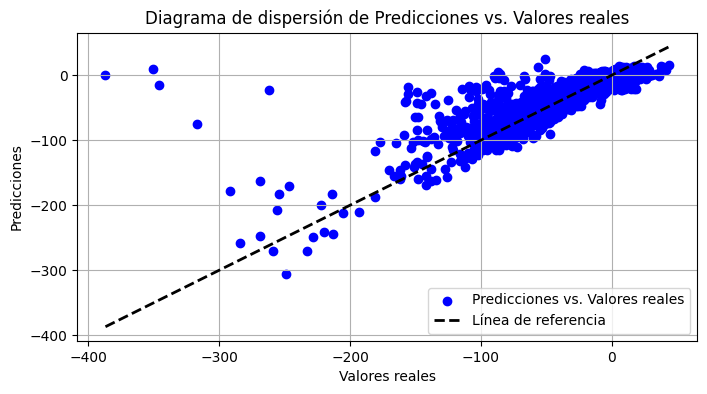

In [53]:
error_nn(preds, y_test, scaler_label)

In [54]:
def plot_test(df, idx_storm):
    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(df['Datetime_pred'], df['y_pred'], color='red', label='Predicción')
    plt.plot(df['Datetime_pred'], df['y_true'], color='blue', label='Valor Real')

    # Añadir título y etiquetas
    date_start = df["Datetime_last_data"].iloc[0].strftime("%y-%m-%d")
    date_end = df["Datetime_last_data"].iloc[-1].strftime("%y-%m-%d")
    plt.title(f'Predicción vs Valor Real de la Tormenta {date_start}-{date_end}')
    plt.xlabel('Fecha')
    plt.ylabel('Dst (nT)')
    plt.legend()

    # Mejorar la apariencia
    plt.grid(True)
    plt.xticks(rotation=0)
    plt.tight_layout()
    path_to_save=f"/content/drive/MyDrive/TFM data/RESULTADOS/SVR_{lookforward}h_res_by_storm/"
    os.makedirs(path_to_save, exist_ok=True)

    plt.savefig(PATH_NN_RES_BY_STORM_PLOTS.format(lookforward, idx_storm+1), dpi=400)
    # Mostrar el gráfico
    plt.show()



def plot_save_test_storms(test_storms, model, scaler_label):
    for idx_storm, df in enumerate(test_storms):
        x_test, y_test, date_last_data, date_pred = create_window_df_nn_test([df], lookback, lookforward, cols_to_use, col_to_predict, scaler_cols)
        X_test = x_test.reshape(x_test.shape[0], -1)
        print("x_test shape : ", X_test.shape, "\ny_test shape:", y_test.shape)

        preds = model.predict(X_test)
        preds_unscaled = scaler_label.inverse_transform(preds.reshape(-1,1))
        y_test_unscaled = scaler_label.inverse_transform(y_test.reshape(-1,1))
        df_to_save = pd.DataFrame(
            {
                "Datetime_last_data": date_last_data,
                "Datetime_pred": date_pred,
                "y_true": np.squeeze(y_test_unscaled),
                "y_pred": np.squeeze(preds_unscaled),
            }
        )
        path_to_save=f"/content/drive/MyDrive/TFM data/RESULTADOS/SVR_{lookforward}h_res_by_storm/"
        os.makedirs(path_to_save, exist_ok=True)
        df_to_save.to_csv(PATH_NN_RES_BY_STORM.format(lookforward, idx_storm+1))
        plot_test(df_to_save, idx_storm)
        error_nn(preds, y_test, scaler_label)

x_test shape :  (223, 120) 
y_test shape: (223,)


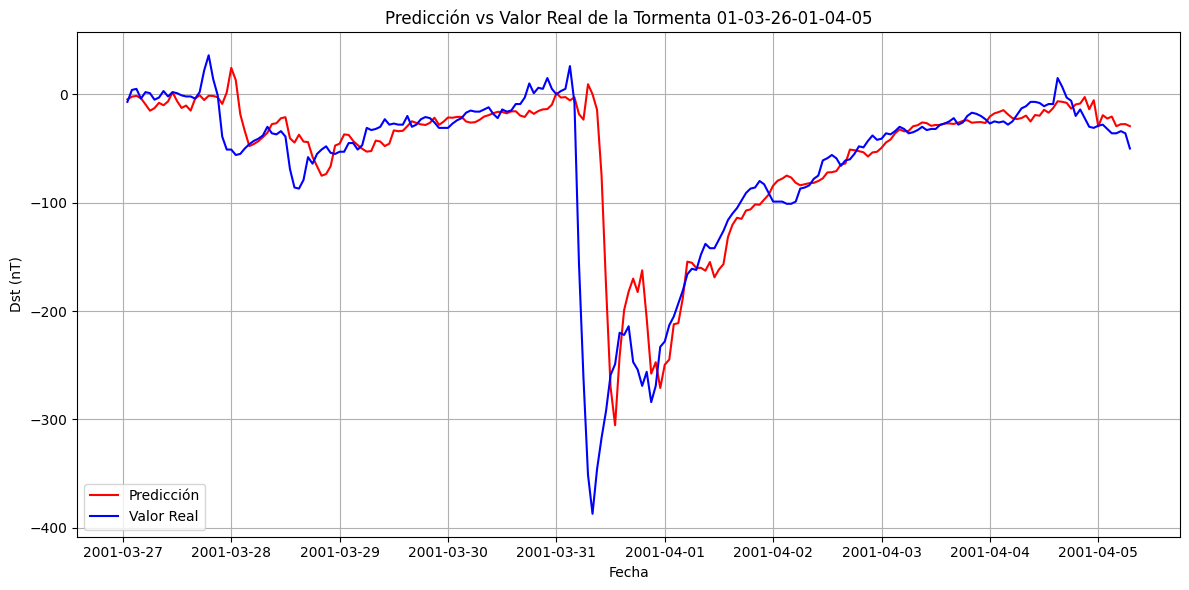

Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,52.861062,2794.29183,21.158415,0.538713,9.254333,0.548496,387.14379


(223,)
(223,)


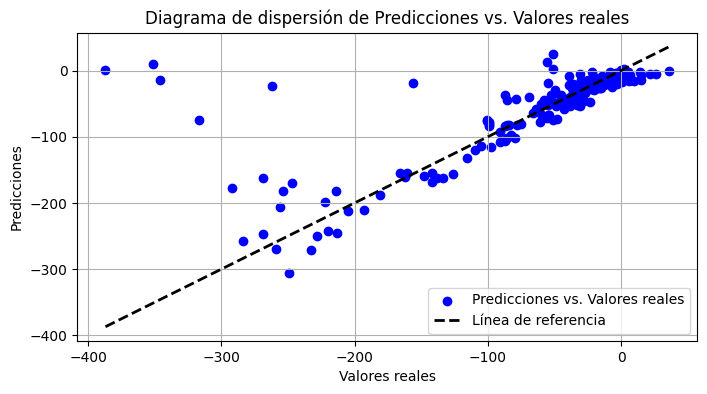

x_test shape :  (328, 120) 
y_test shape: (328,)


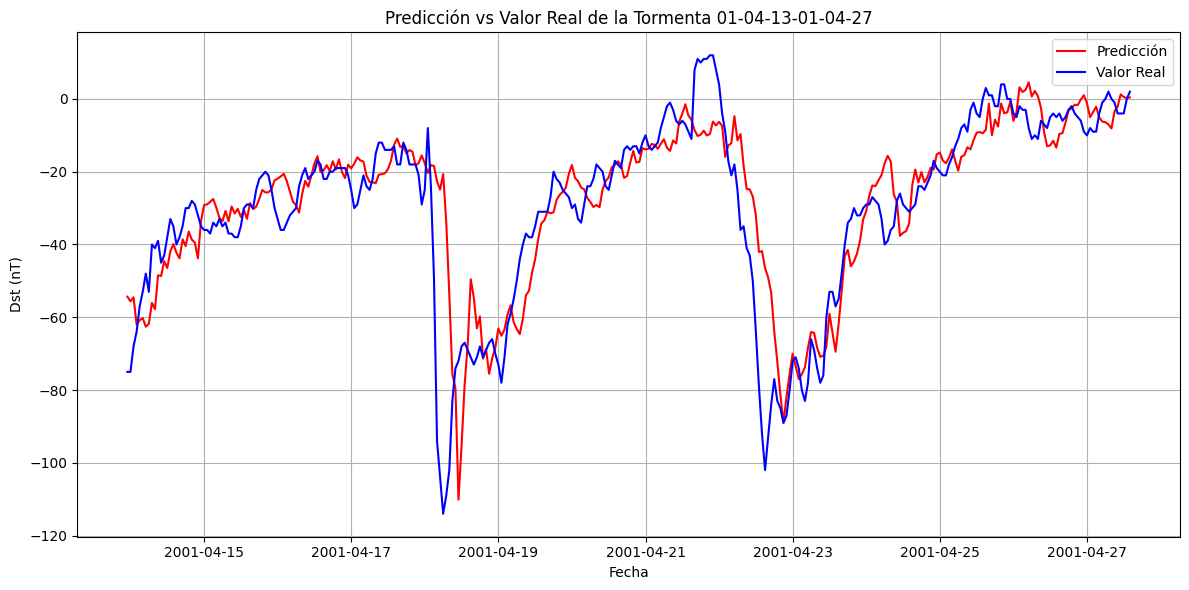

(328,)
(328,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,14.074752,198.098657,8.584565,0.691892,5.58738,0.695085,93.347532


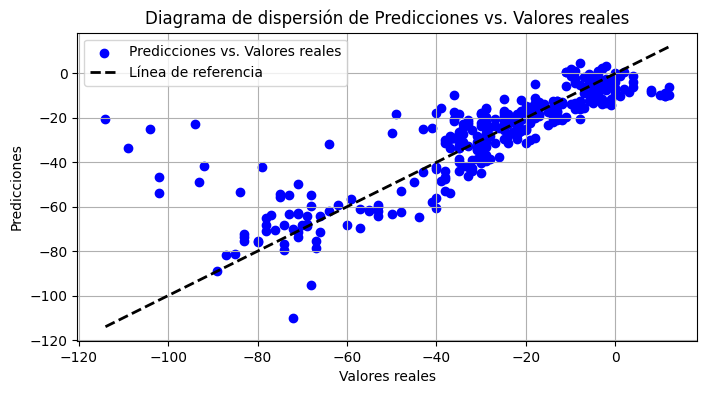

x_test shape :  (272, 120) 
y_test shape: (272,)


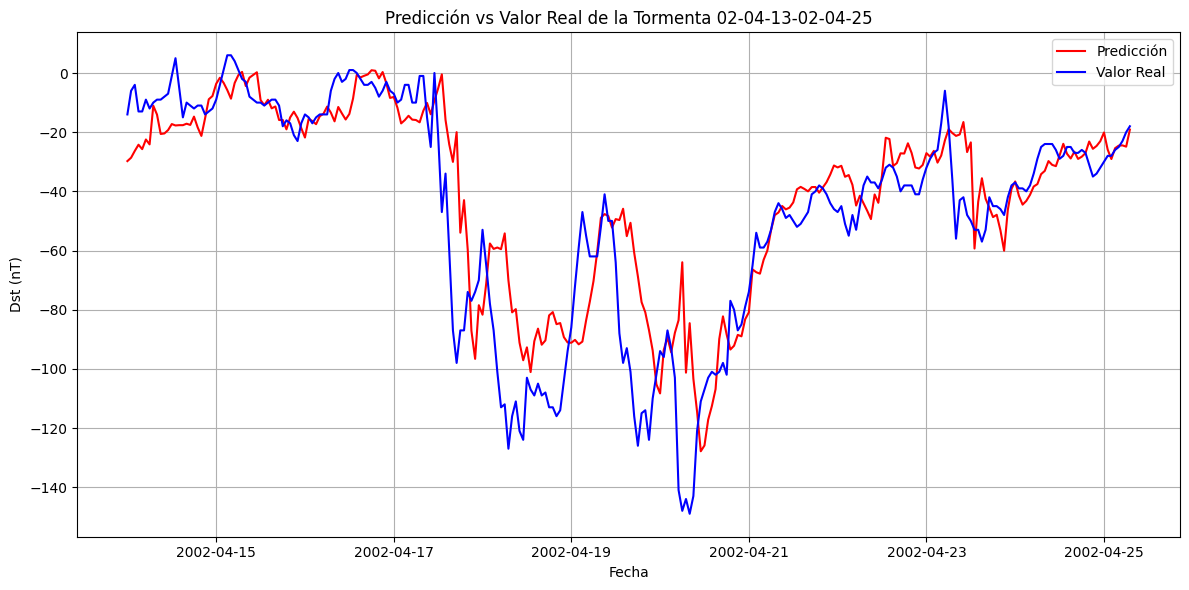

(272,)
(272,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,19.19503,368.449188,12.706374,0.743785,8.340924,0.759552,84.023741


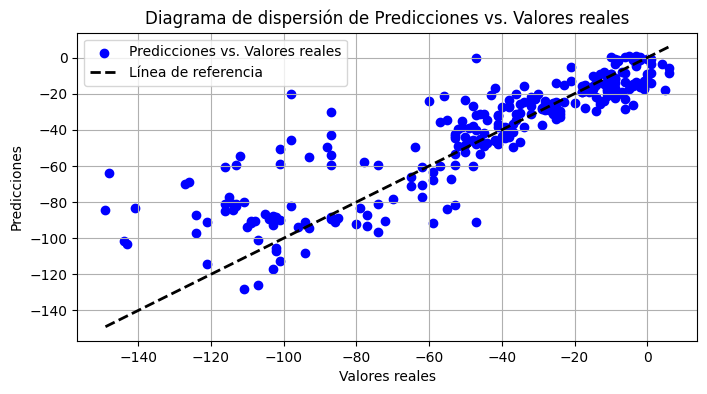

x_test shape :  (314, 120) 
y_test shape: (314,)


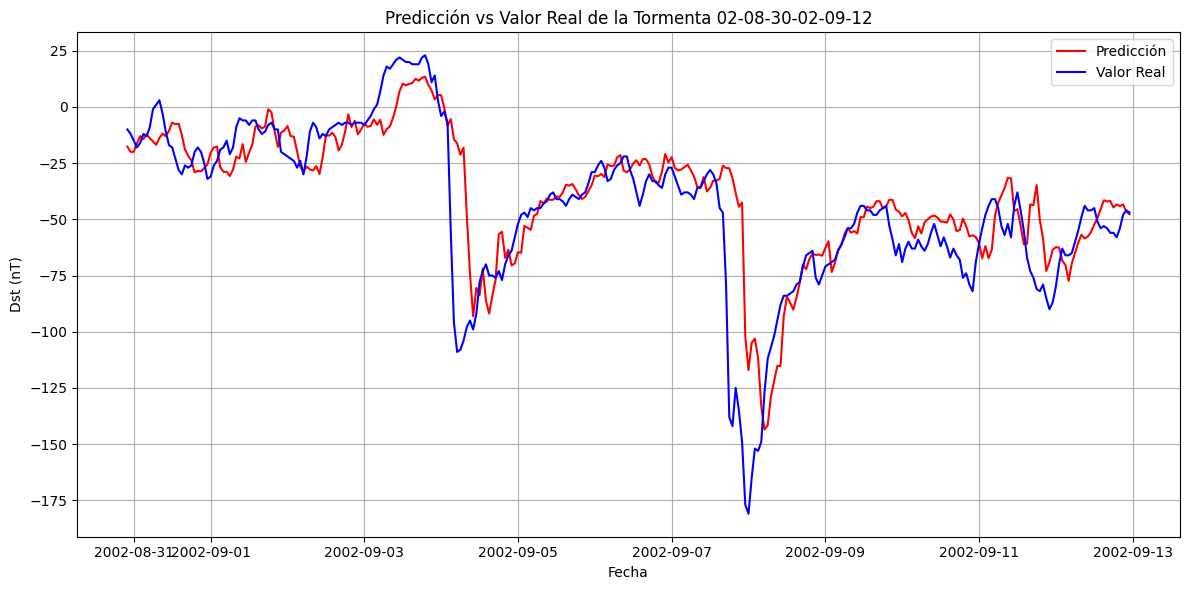

(314,)
(314,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,21.629401,467.83097,12.67615,0.632251,7.999615,0.64959,110.694878


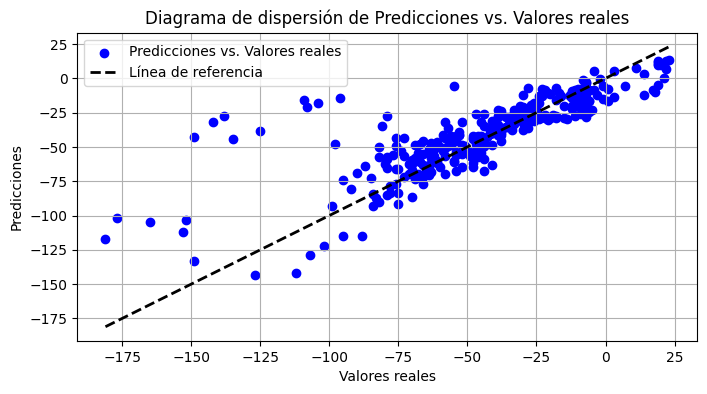

x_test shape :  (330, 120) 
y_test shape: (330,)


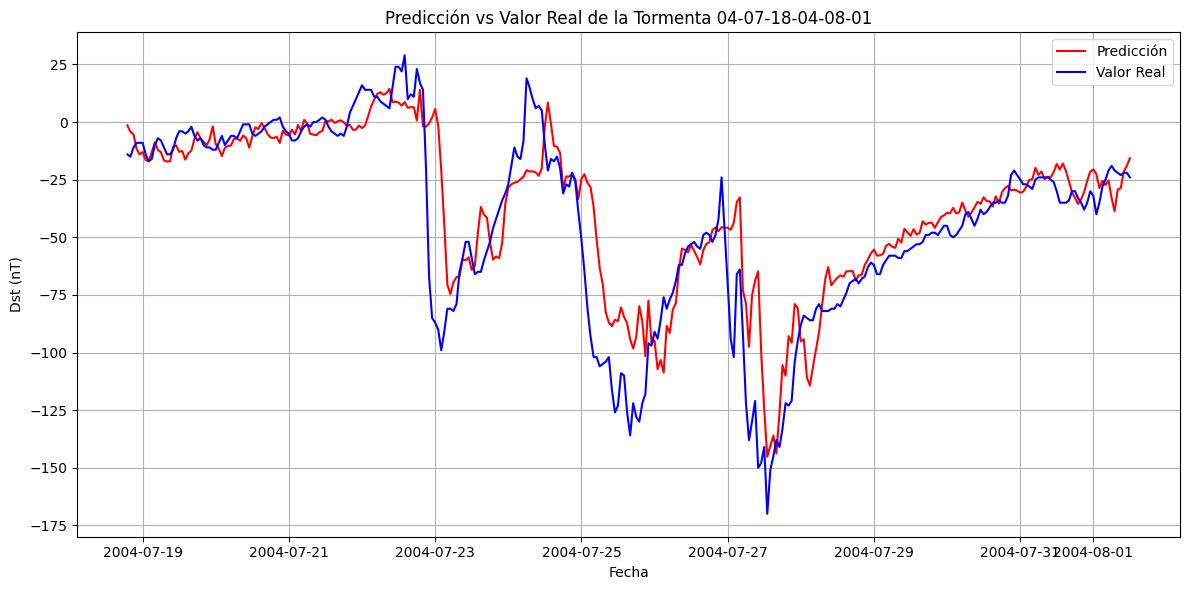

(330,)
(330,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,20.007281,400.291279,12.532197,0.764091,6.680216,0.781653,92.64404


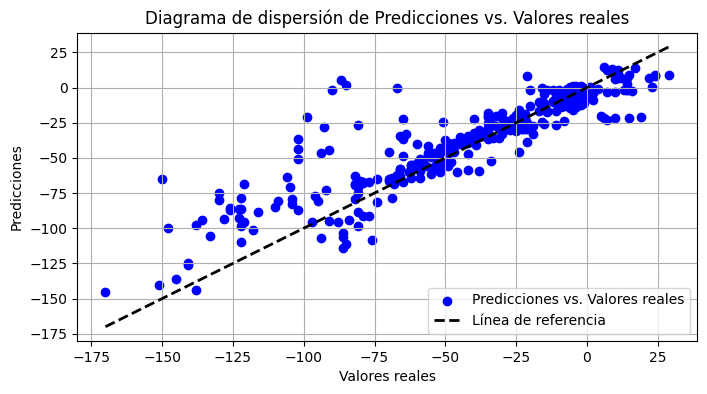

x_test shape :  (223, 120) 
y_test shape: (223,)


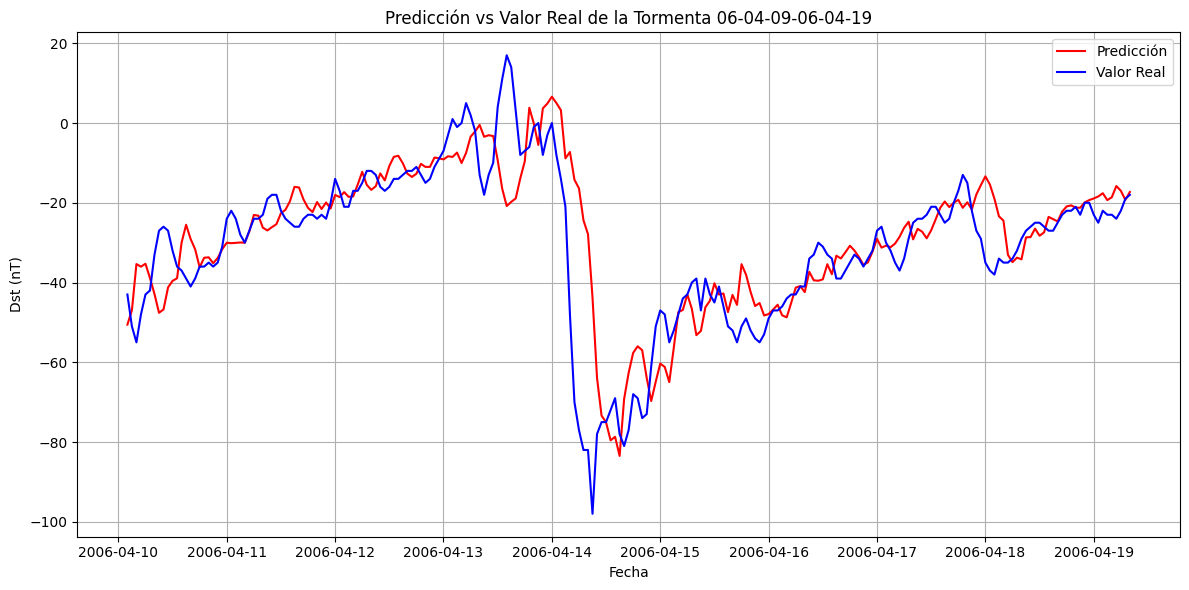

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,12.170907,148.130972,7.301753,0.609604,4.582333,0.619746,60.62549


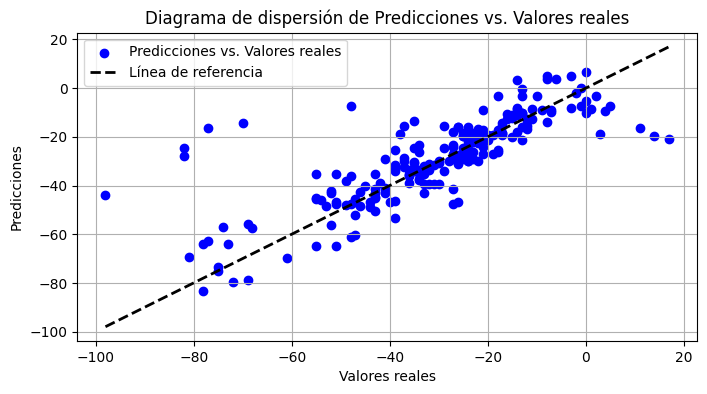

x_test shape :  (223, 120) 
y_test shape: (223,)


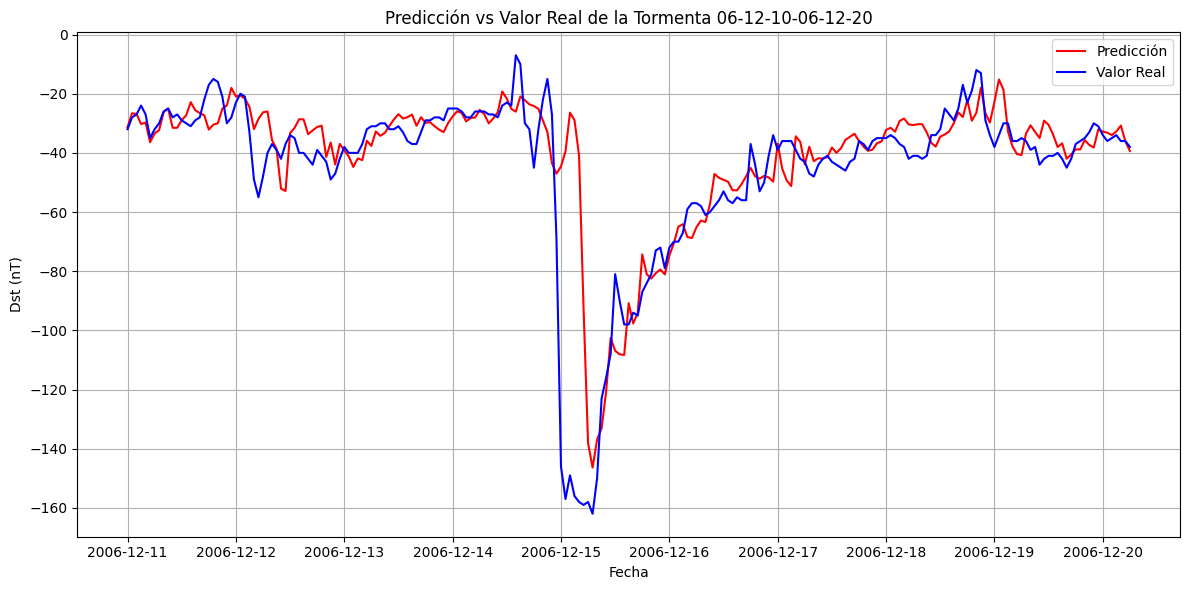

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,19.808081,392.360055,8.790021,0.530249,4.626142,0.547692,127.005782


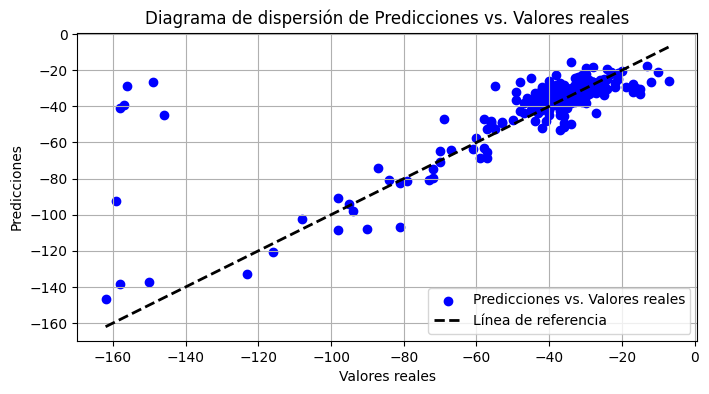

x_test shape :  (223, 120) 
y_test shape: (223,)


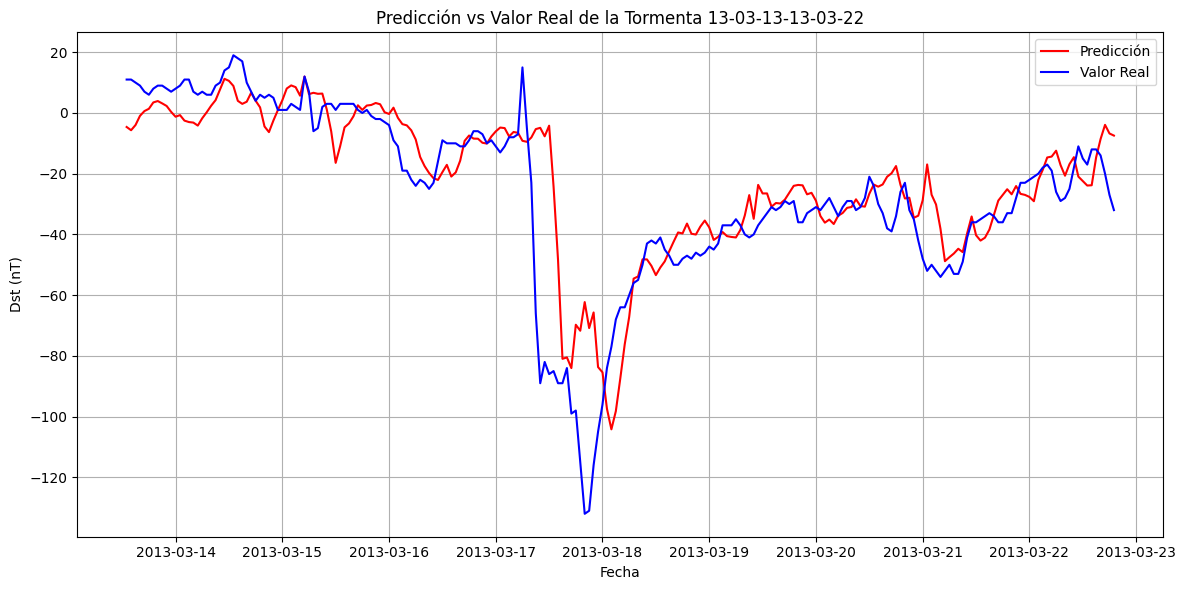

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,16.581778,274.95535,9.98195,0.676312,6.266804,0.691327,84.103202


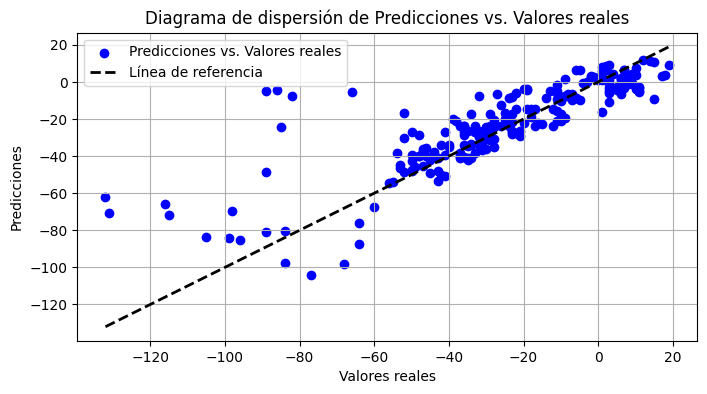

x_test shape :  (223, 120) 
y_test shape: (223,)


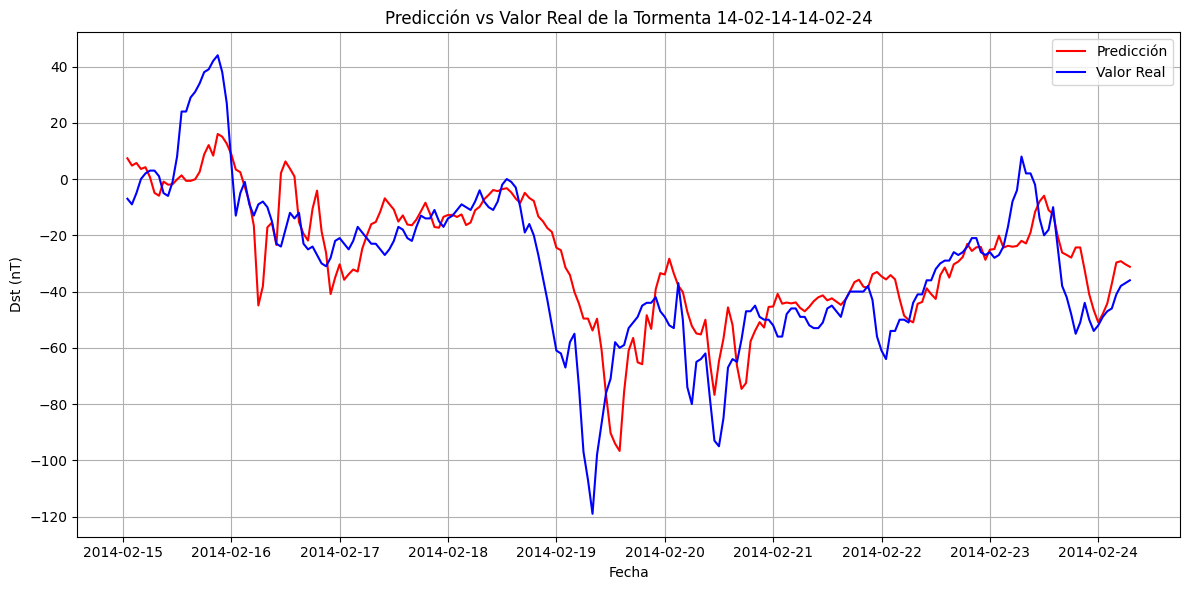

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,16.348702,267.280058,11.804925,0.649325,7.917006,0.661541,65.163483


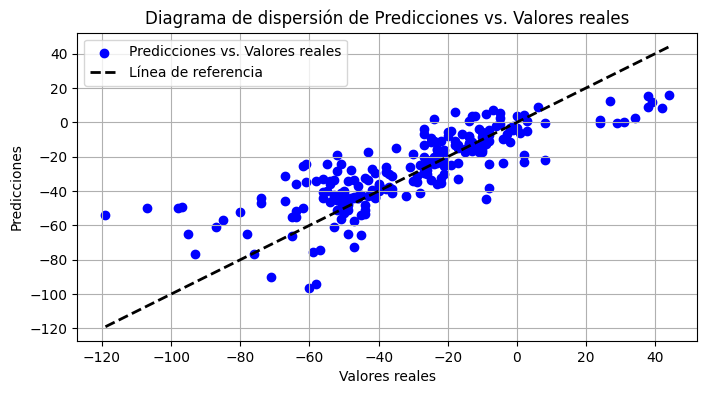

In [55]:
plot_save_test_storms(test_storms, model, scaler_label)